Based on the 'activation maximization' technique suggested in [this](https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf) paper. 

We will view the layers of the (pretrained) GoogLeNet just like in [this](https://distill.pub/2017/feature-visualization/) post.

## Import useful libraries 

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models

## Import a pretrained GoogLeNet

In [4]:
googlenet = models.googlenet(pretrained = True)

googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
# We now freeze the parameters of our pretrained model
for param in googlenet.parameters():
    param.requires_grad_(False)

In [12]:
# the first inception layer in googlenet i.e. layer 3a
googlenet.inception3a

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchN

In [80]:
# We will register a forward hook to get the output of the layers

activation = {} # to store the activation  of a layer
def create_hook(name):
    def hook(m, i, o):
        # copy the output of the given layer
        activation[name] = o
       
    return hook


# register a forward hook for layer 3a i.e. the first inception layer
googlenet.inception3a.register_forward_hook(create_hook('3a'))

## Create an input image 

The starting image will consist of random values for the pixels

In [81]:
# normalize the input image to have appropriate mean and standard deviation
from torchvision import transforms



normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [82]:
img_tensor = normalize(torch.rand((3, 224, 224))).requires_grad_(True)
print(img_tensor)

tensor([[[-1.4817e+00, -2.0035e+00,  1.1042e+00,  ..., -1.1801e+00,
          -1.4074e+00, -5.6769e-01],
         [-1.4809e+00,  7.6189e-01,  1.0031e+00,  ..., -1.0567e-01,
          -6.6042e-01, -6.7279e-01],
         [-2.5688e-01, -1.3087e-03,  1.1965e+00,  ..., -3.2524e-01,
           1.4646e+00,  5.9072e-01],
         ...,
         [-6.8136e-01, -6.2218e-01, -2.4216e-01,  ...,  1.8936e+00,
           2.0212e+00, -1.0909e+00],
         [-1.1433e+00,  6.8229e-01, -1.0789e+00,  ..., -4.4533e-01,
          -3.3512e-01,  1.5296e+00],
         [ 1.4925e+00, -3.3470e-01,  1.3701e+00,  ...,  4.9764e-01,
           1.8198e+00, -1.6367e+00]],

        [[ 2.4139e+00,  2.0286e+00,  1.4621e+00,  ...,  2.2180e+00,
           2.0142e+00, -1.5036e+00],
         [-1.0817e+00,  1.0144e+00,  1.6365e+00,  ..., -1.5649e+00,
          -1.6090e+00, -4.4474e-01],
         [ 9.0997e-01, -9.2296e-01,  1.0092e+00,  ...,  2.0674e+00,
           2.2384e+00, -6.1245e-01],
         ...,
         [ 9.6140e-01, -3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


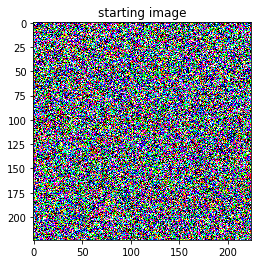

In [83]:
plt.imshow(img_tensor.clone().detach().numpy().transpose(1,2,0)) # for plt.imshow() the channel-dimension is the last
                                                                 # therefore use transpose to permute axis
                                                                 # negative value will be clipped
plt.title('starting image')
plt.show()

In [84]:
from torch import optim

In [85]:
optimizer = optim.Adam([img_tensor], lr =0.04)

In [97]:
optimizer.zero_grad()

# Since we are not training googlenet here, therefore we should use evaluation mode 
# this is because batch-normalization layers in googlenet will have different behaviour in traning vs evaluation modes
googlenet.eval()
googlenet(img_tensor.unsqueeze(0))
Inception3a_out = activation['3a'].squeeze()

loss = -Inception3a_out[0].flatten().sum()
print(loss)
loss.backward()
optimizer.step()

img_tensor = normalize(img_tensor)


tensor(-1716.9727, grad_fn=<NegBackward>)


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


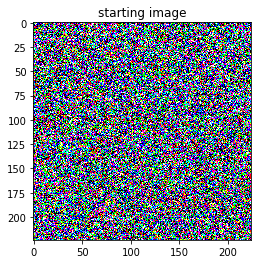

In [96]:
plt.imshow(img_tensor.clone().detach().numpy().transpose(1,2,0)) # for plt.imshow() the channel-dimension is the last
                                                                 # therefore use transpose to permute axis
                                                                 # negative value will be clipped
plt.title('starting image')
plt.show()